# (14) Overlay (rivalry among digits)

**Motivation**: host = ```Any```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 1
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:1  ———  host: chewie

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from analysis.overlay import *

## Poisson

In [4]:
models2load = {
    'iterative': dict(
        model_name='poisson_MNIST_t-32_z-[128]_<jacob|mlp>',
        fit_name='u:(8.0)-du:(7.0)_b200-ep500-lr(0.002)_beta(16:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_13,10:55)',
        device=device,
        shuffle=False,
    ),
    'amortized': dict(
        model_name='poisson_MNIST_t-1_z-[128]_<mlp|mlp>',
        fit_name='b200-ep500-lr(0.002)_beta(1:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_13,17:45)',
        device=device,
        shuffle=False,
    )
}

In [5]:
trainers = {
    name: load_model(**kwargs)[0] for
    name, kwargs in models2load.items()
}
tr = trainers['iterative']
shape = (-1, *tr.model.cfg.input_sz)

100%|█████████████████████████████████| 50/50 [01:41<00:00,  2.02s/it]


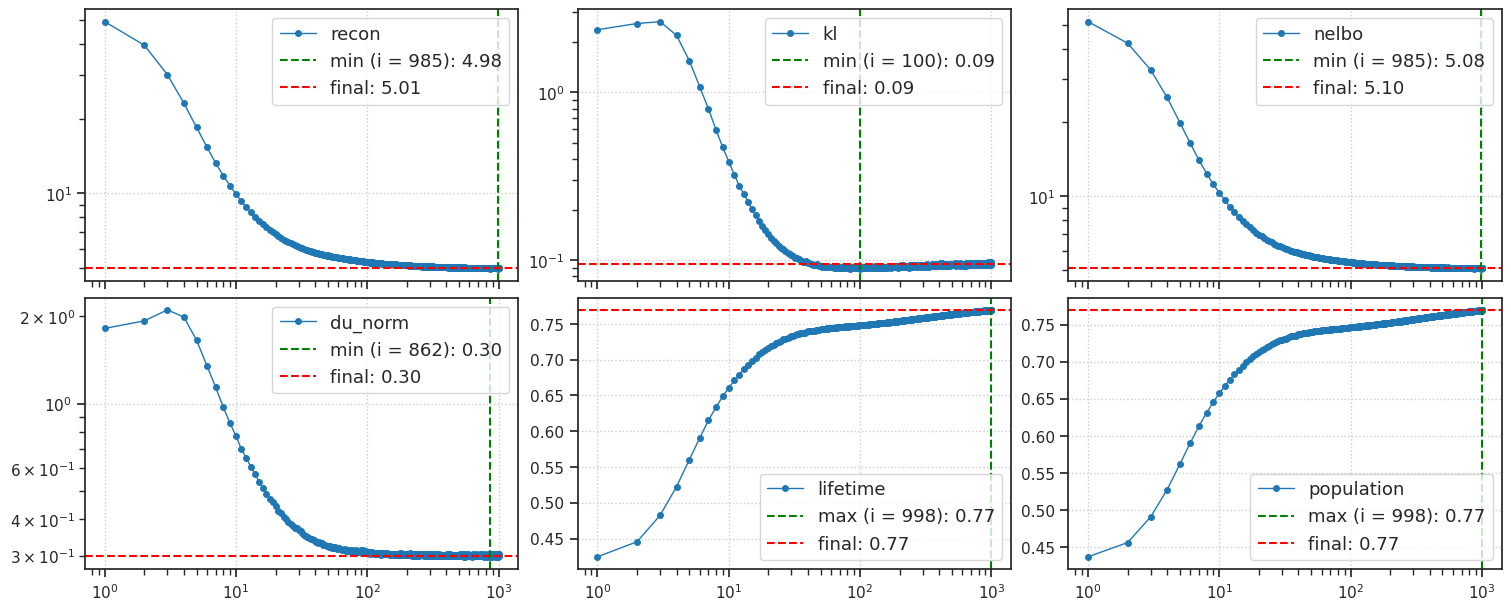

In [6]:
# results = tr.analysis('vld', seq_total=1000)
# _ = plot_convergence(results, color='C0')

## effect of t

In [6]:
kws = dict(
    tr=trainers['iterative'],
    alpha=None,
    t_recon=None,
    t_halluc=None,
    clip=True,
    use_pred=True,
    full_data=True,
    verbose=False,
)

In [7]:
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]
times = [8, 16, 32, 64, 128, 256]
looper = tqdm(
    itertools.product(alphas, times, times),
    total=len(alphas)* len(times) ** 2,
)
df = collections.defaultdict(list)
for alpha, t_recon, t_halluc in looper:
    # fit
    kws['alpha'] = alpha
    kws['t_recon'] = t_recon
    kws['t_halluc'] = t_halluc
    results, accu_true, accu_over = perform_overlay_analysis(**kws)

    # info
    df['alpha'].append(alpha)
    df['t_recon'].append(t_recon)
    df['t_halluc'].append(t_halluc)
    df['label'].append(f"({t_recon},{t_halluc})")

    # results
    df['accu_true'].append(accu_true)
    df['accu_over'].append(accu_over)
    df['accu_ratio'].append(accu_true / (accu_true + accu_over))
    df['mse_true_mean'].append(np.mean(results['mse_true']))
    df['mse_over_mean'].append(np.mean(results['mse_over']))
    df['mse_true_median'].append(np.median(results['mse_true']))
    df['mse_over_median'].append(np.median(results['mse_over']))

df = pd.DataFrame(df)

100%|██████████████████████████████████████| 180/180 [5:54:42<00:00, 118.24s/it]


In [8]:
# save_obj(
#     obj=df,
#     file_name='df_overlay',
#     save_dir=tmp_dir,
#     mode='df',
# )

[PROGRESS] 'df_overlay.df' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

In [10]:
df

,alpha,t_recon,t_halluc,label,accu_true,accu_over,accu_ratio,mse_true_mean,mse_over_mean,mse_true_median,mse_over_median
0,0.1,8,8,"(8,8)",0.9572,0.0064,0.993358,13.386236,77.713058,13.069352,76.086838
1,0.1,8,16,"(8,16)",0.9556,0.0060,0.993760,13.355899,78.910378,12.949184,77.142517
2,0.1,8,32,"(8,32)",0.9512,0.0063,0.993420,13.818367,80.427666,13.177250,78.653091
3,0.1,8,64,"(8,64)",0.9435,0.0088,0.990759,15.910430,80.607239,14.855879,78.672676
4,0.1,8,128,"(8,128)",0.9317,0.0088,0.990643,21.202047,79.458519,19.591816,77.081055
...,...,...,...,...,...,...,...,...,...,...,...
175,0.5,256,16,"(256,16)",0.4540,0.4550,0.499450,35.804745,35.473125,32.616024,31.924936
176,0.5,256,32,"(256,32)",0.4377,0.4613,0.486874,38.065495,37.750259,34.146027,33.770164
177,0.5,256,64,"(256,64)",0.4397,0.4379,0.501026,40.971256,41.240688,36.629066,36.735554
178,0.5,256,128,"(256,128)",0.4346,0.4334,0.500691,44.962044,44.692577,40.626137,40.854218


In [22]:
df = pd.read_pickle(pjoin(tmp_dir, 'df_overlay.df'))

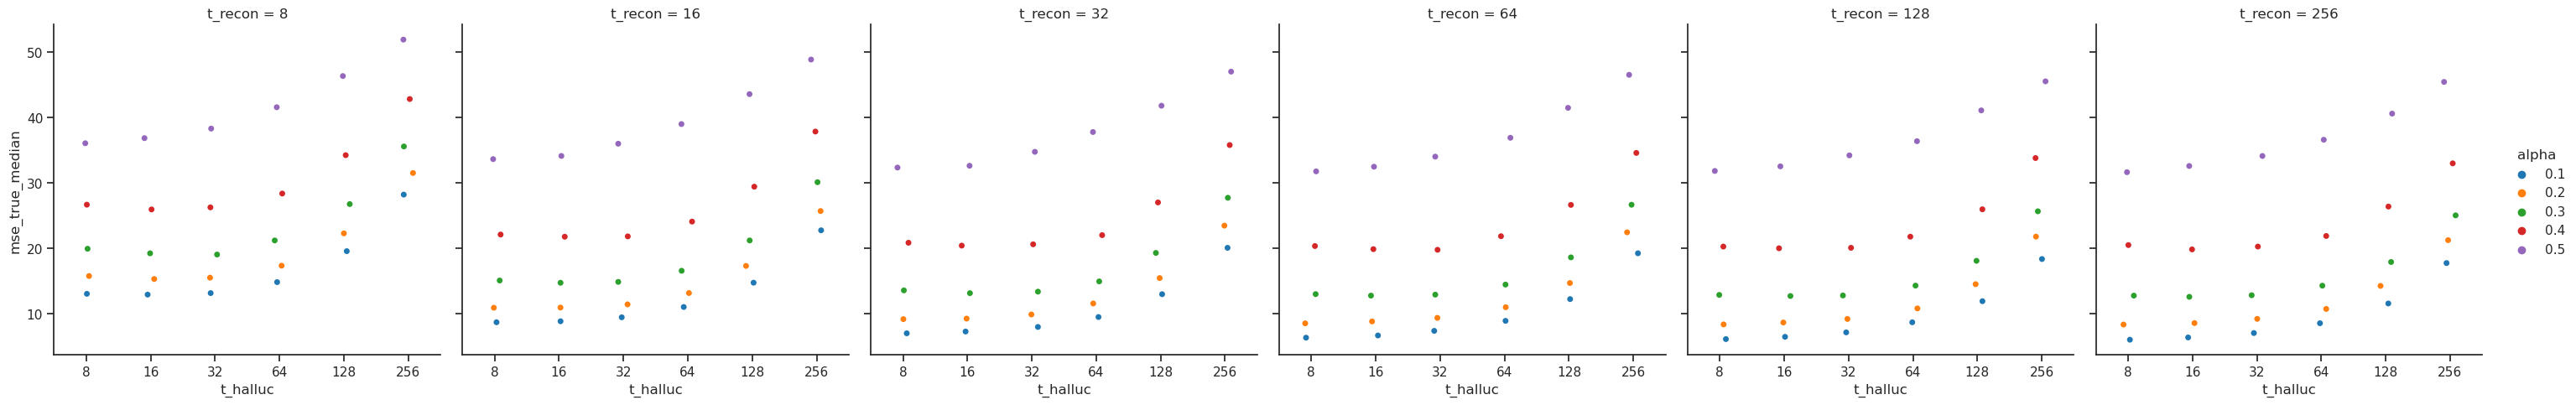

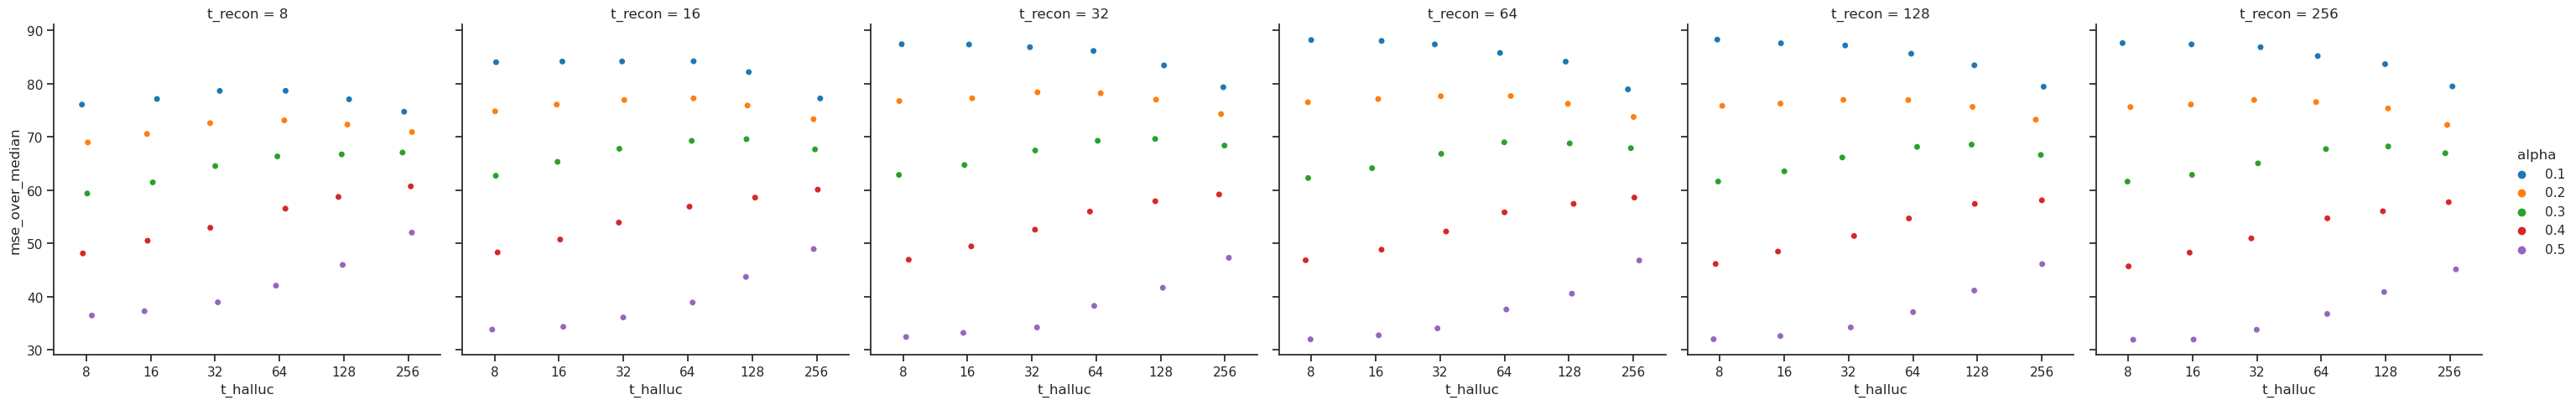

In [23]:
sns.catplot(
    data=df,
    x='t_halluc',
    y='mse_true_median',
    col='t_recon',
    hue='alpha',
    palette='tab10',
)

sns.catplot(
    data=df,
    x='t_halluc',
    y='mse_over_median',
    col='t_recon',
    hue='alpha',
    palette='tab10',
)

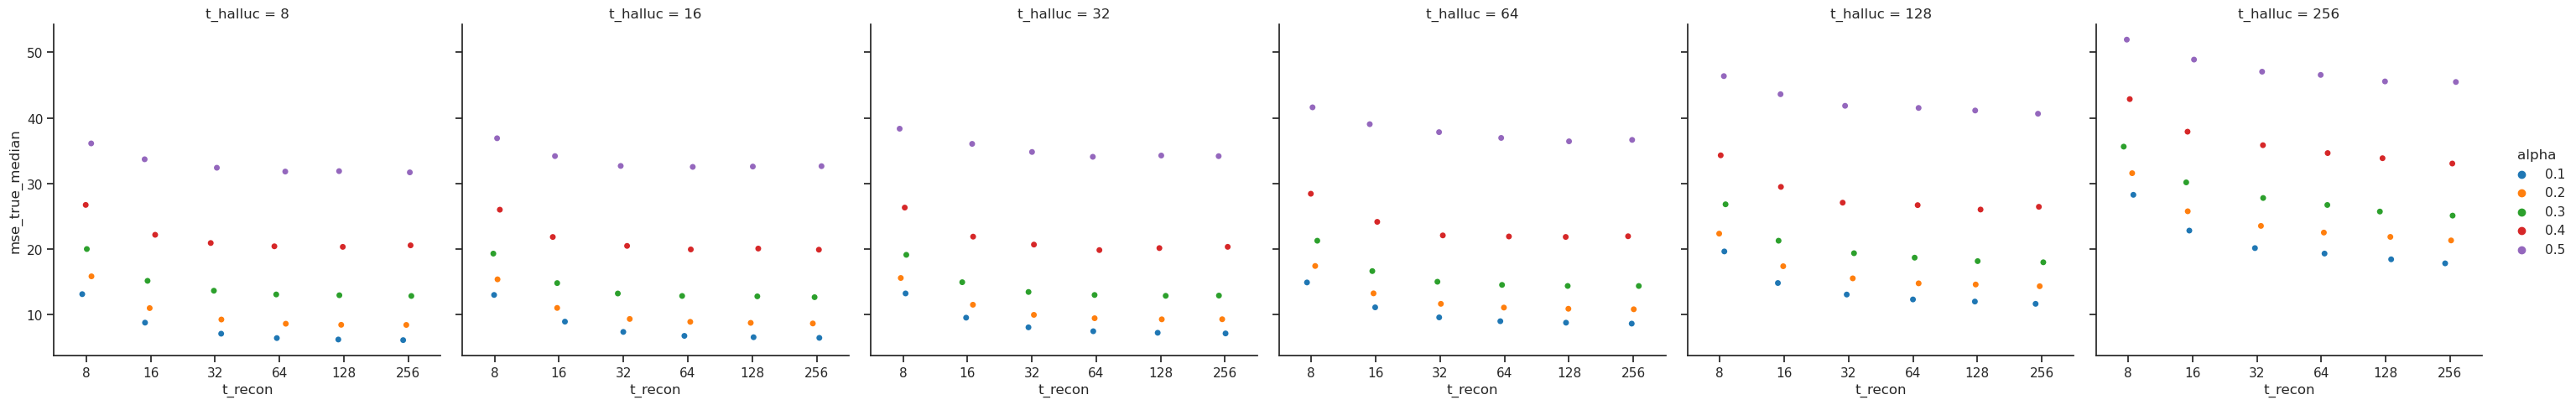

In [13]:
sns.catplot(
    data=df,
    col='t_halluc',
    y='mse_true_median',
    x='t_recon',
    hue='alpha',
    palette='tab10',
)

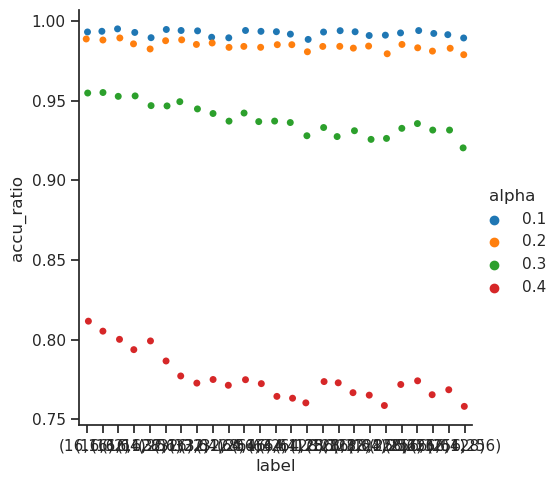

In [11]:
sns.catplot(
    data=df,
    x='label',
    y='accu_ratio',
    hue='alpha',
    palette='tab10',
)

In [8]:
kws = dict(
    tr=trainers['iterative'],
    alpha=None,
    t_recon=None,
    t_halluc=None,
    clip=False,
    use_pred=True,
    full_data=True,
    verbose=False,
)

In [9]:
alphas = [0.1, 0.4, 0.5]
times = [0, 2, 4, 8, 16]
t_recon = 16

looper = tqdm(
    itertools.product(alphas, times),
    total=len(alphas)* len(times),
)
df_2 = collections.defaultdict(list)
for alpha, t_halluc in looper:
    # fit
    kws['alpha'] = alpha
    kws['t_recon'] = t_recon
    kws['t_halluc'] = t_halluc
    results, accu_true, accu_over = perform_overlay_analysis(**kws)

    # info
    df_2['alpha'].append(alpha)
    df_2['t_recon'].append(t_recon)
    df_2['t_halluc'].append(t_halluc)
    df_2['label'].append(f"({t_recon},{t_halluc})")

    # results
    df_2['accu_true'].append(accu_true)
    df_2['accu_over'].append(accu_over)
    df_2['accu_ratio'].append(accu_true / (accu_true + accu_over))
    df_2['mse_true'].append(results['mse_true'].mean())
    df_2['mse_over'].append(results['mse_over'].mean())

df_2 = pd.DataFrame(df_2)

100%|███████████████████████████████████████████| 15/15 [03:10<00:00, 12.67s/it]


In [ ]:
# save_obj(
#     obj=df_2,
#     file_name='df_overlay_t-256',
#     save_dir=tmp_dir,
#     mode='df',
# )

[(8.0, 25.0)]

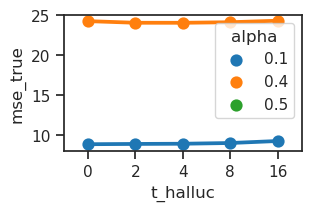

In [11]:
fig, ax = create_figure()

sns.pointplot(
    data=df_2,
    y='mse_true',
    hue='alpha',
    palette='tab10',
    x='t_halluc',
    ax=ax,
)
ax.set(ylim=(8, 25))

<Axes: xlabel='t_halluc', ylabel='mse_true'>

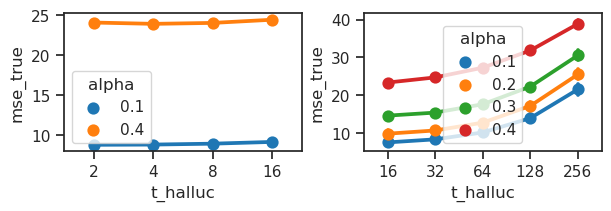

In [22]:
fig, axes = create_figure(1, 2)

sns.pointplot(
    data=df_2,
    y='mse_true',
    hue='alpha',
    palette='tab10',
    x='t_halluc',
    ax=axes[0],
)
sns.pointplot(
    data=df,
    y='mse_true',
    hue='alpha',
    palette='tab10',
    x='t_halluc',
    ax=axes[1],
)

## Overlaid MNIST

In [15]:
alpha = 0.3

### iterative

In [16]:
kws = dict(
    tr=trainers['iterative'],
    alpha=alpha,
    t_recon=64,
    t_halluc=None,
    use_pred=True,
    full_data=True,
    verbose=True,
)

kws['t_halluc'] = 64
results_64, accu_true_64, accu_over_64 = perform_overlay_analysis(**kws)

kws['t_halluc'] = 32
results_32, accu_true_32, accu_over_32 = perform_overlay_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [00:43<00:00,  6.85it/s]


In [17]:
accu_true_32, accu_true_64

(0.8764, 0.8702)

In [18]:
accu_true_32 / (accu_true_32 + accu_over_32), accu_true_64 / (accu_true_64 + accu_over_64)

(0.9350261389096342, 0.9380187560633826)

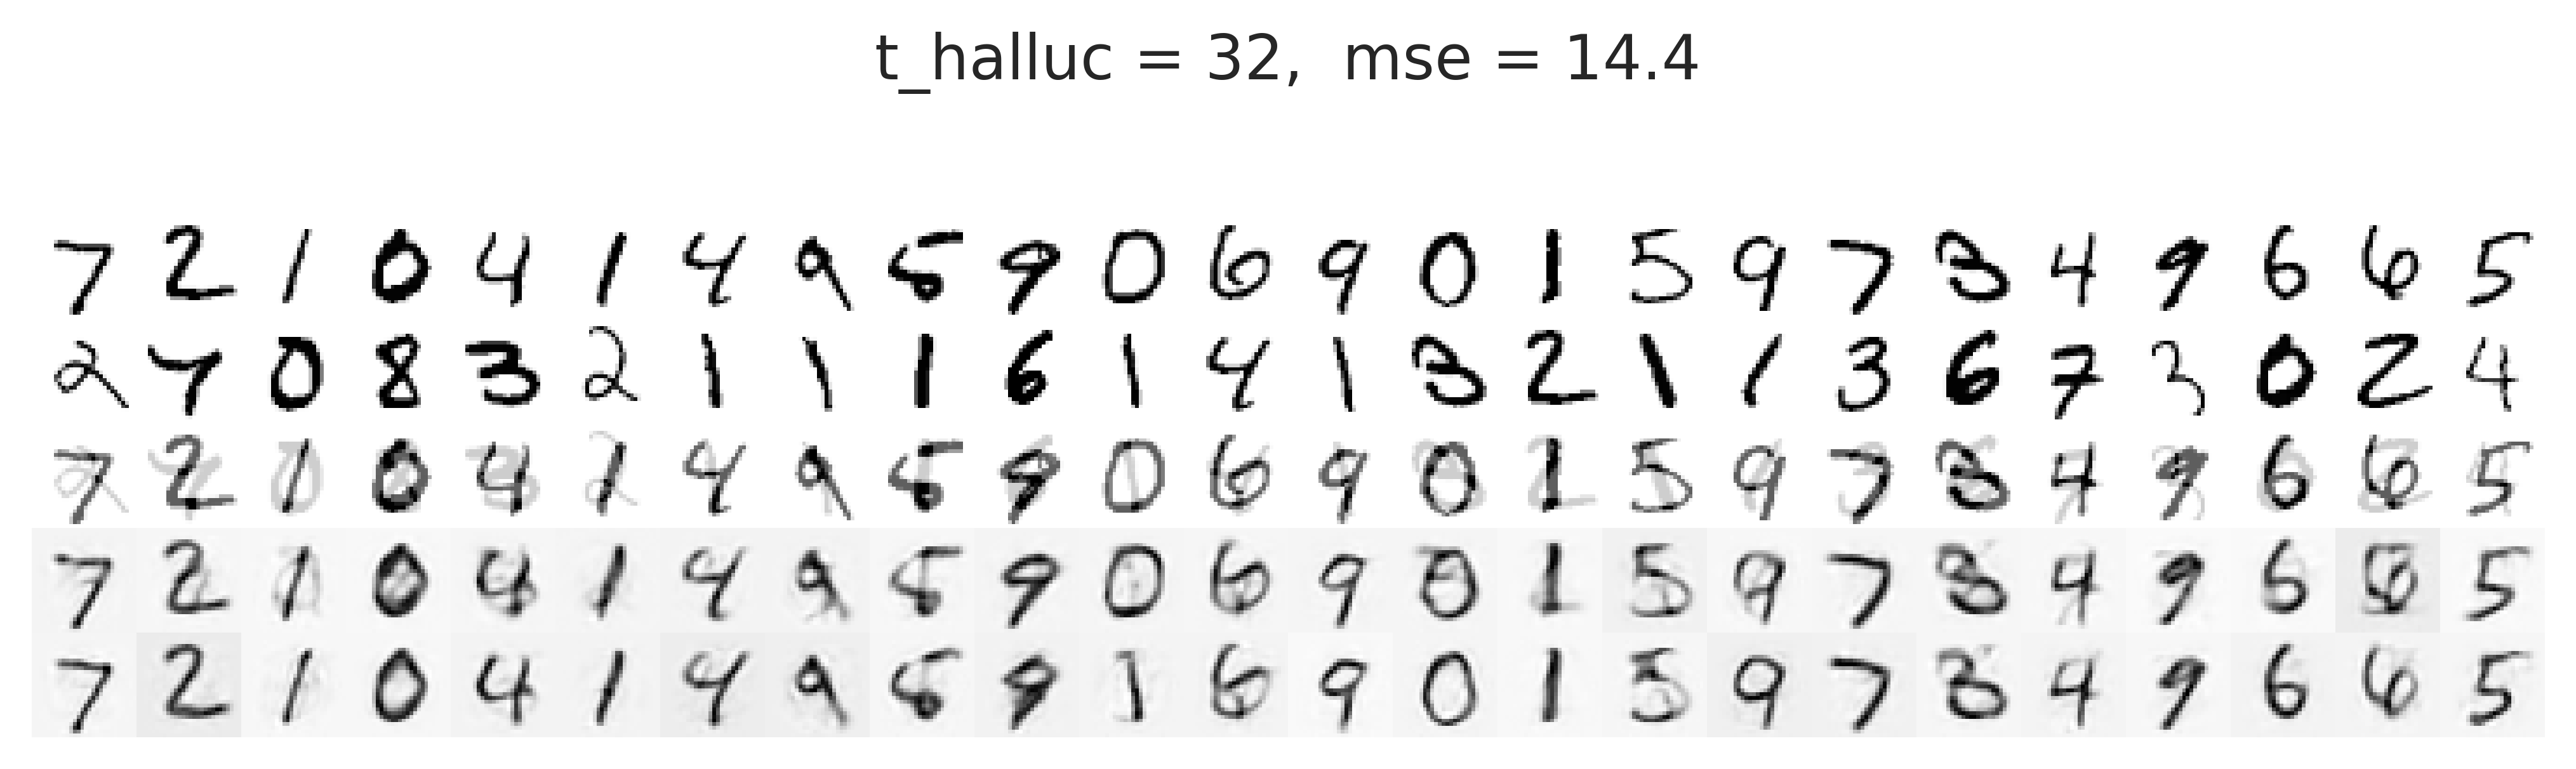

In [19]:
num = 24
x2p = np.concatenate([
    results_32['x_true'][:num],
    results_32['x_over'][:num],
    results_32['x_inpt'][:num],
    results_32['y_recon'][:num].reshape(shape),
    results_32['y_halluc'][:num].reshape(shape),
])
fig, ax = plot_weights(x2p, nrows=5, pad=0, dpi=500, cmap='Greys', display=False)
fig.suptitle(f"t_halluc = 32,  mse = {np.median(results_64['mse_true']):0.1f}", fontsize=14, y=0.85)
display(fig)

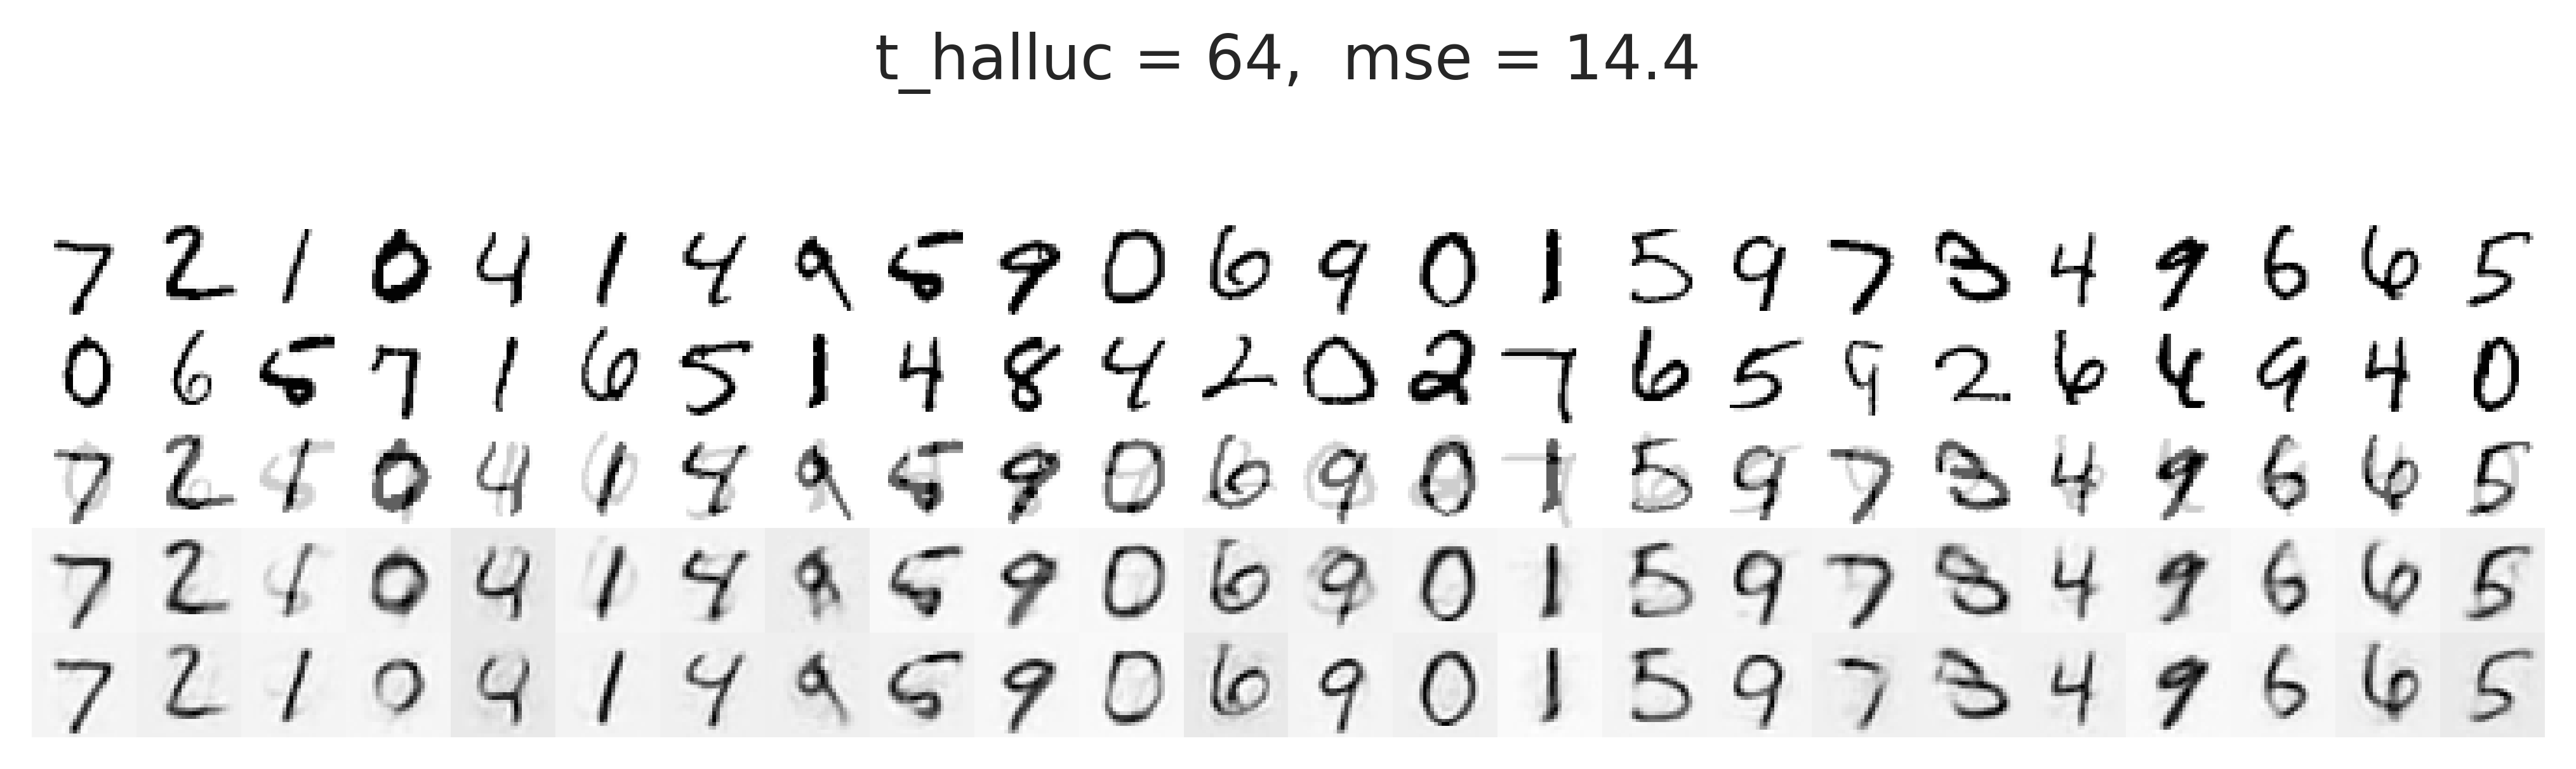

In [20]:
num = 24
x2p = np.concatenate([
    results_64['x_true'][:num],
    results_64['x_over'][:num],
    results_64['x_inpt'][:num],
    results_64['y_recon'][:num].reshape(shape),
    results_64['y_halluc'][:num].reshape(shape),
])
fig, ax = plot_weights(x2p, nrows=5, pad=0, dpi=500, cmap='Greys', display=False)
fig.suptitle(f"t_halluc = 64,  mse = {np.median(results_64['mse_true']):0.1f}", fontsize=14, y=0.85)
display(fig)

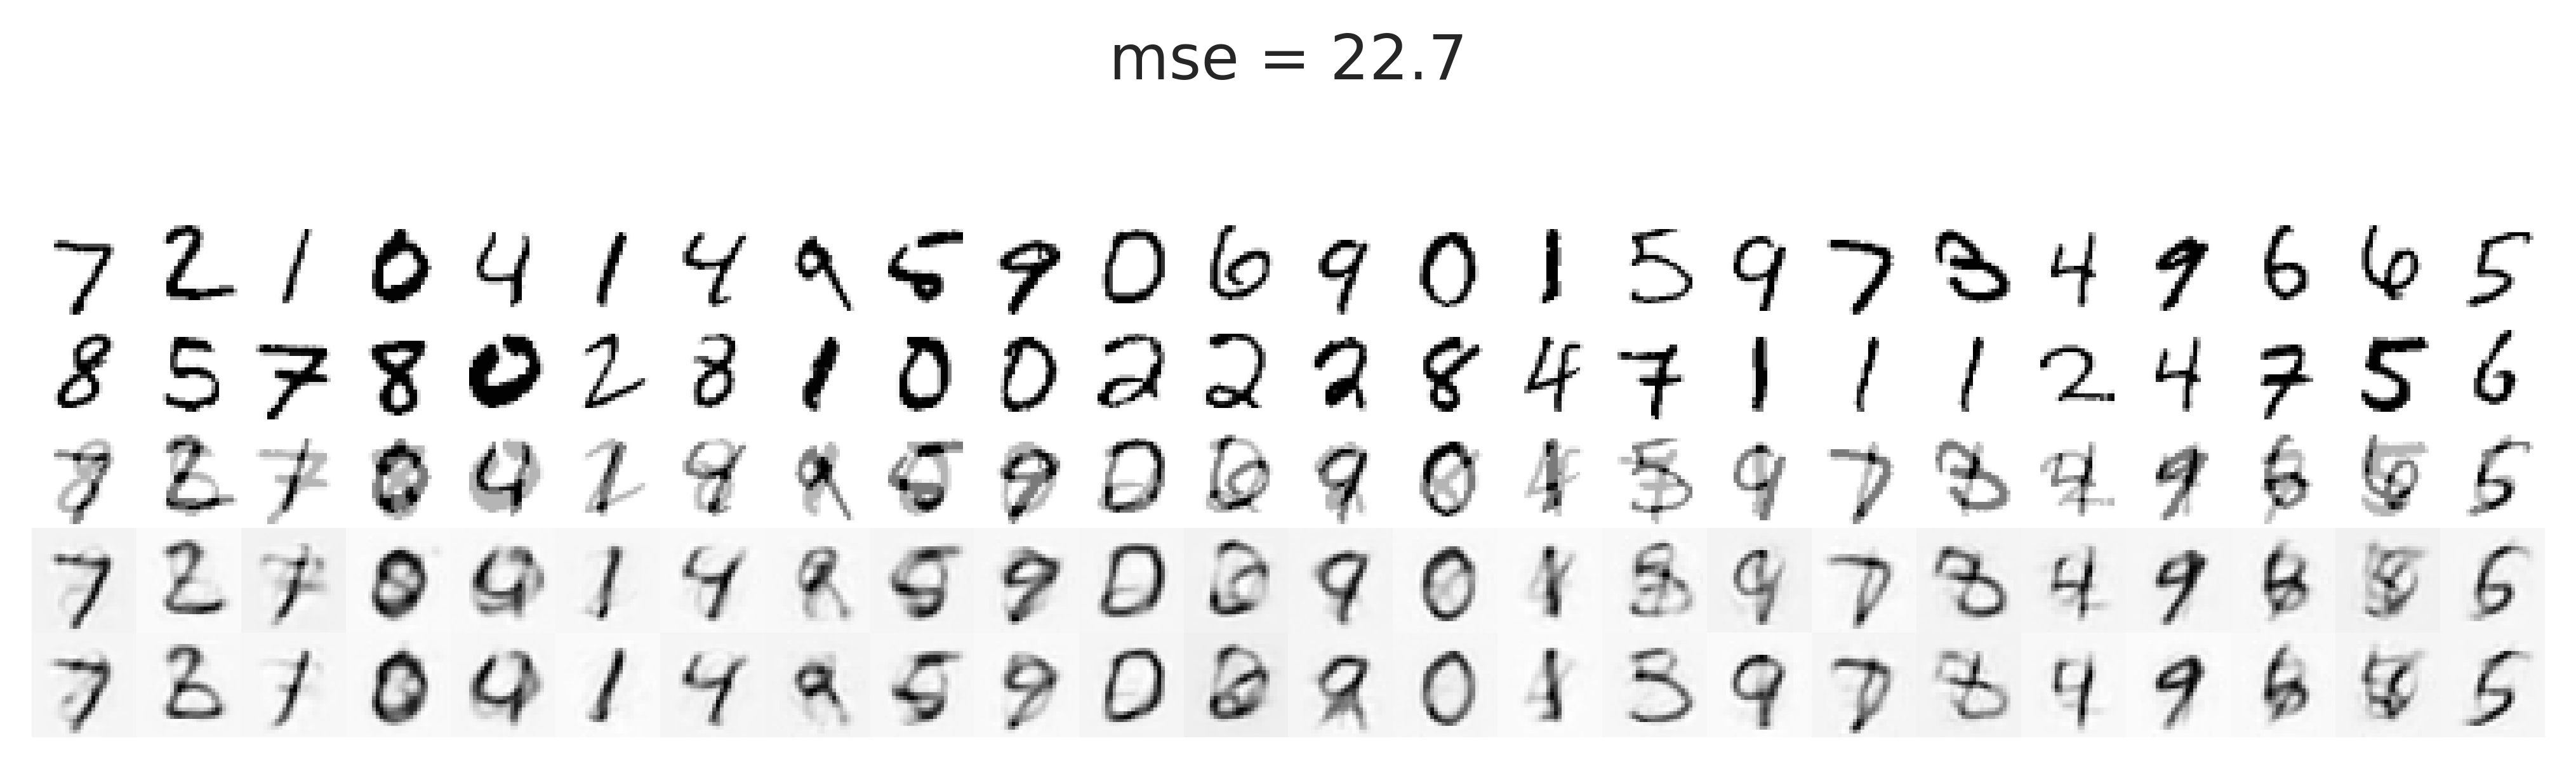

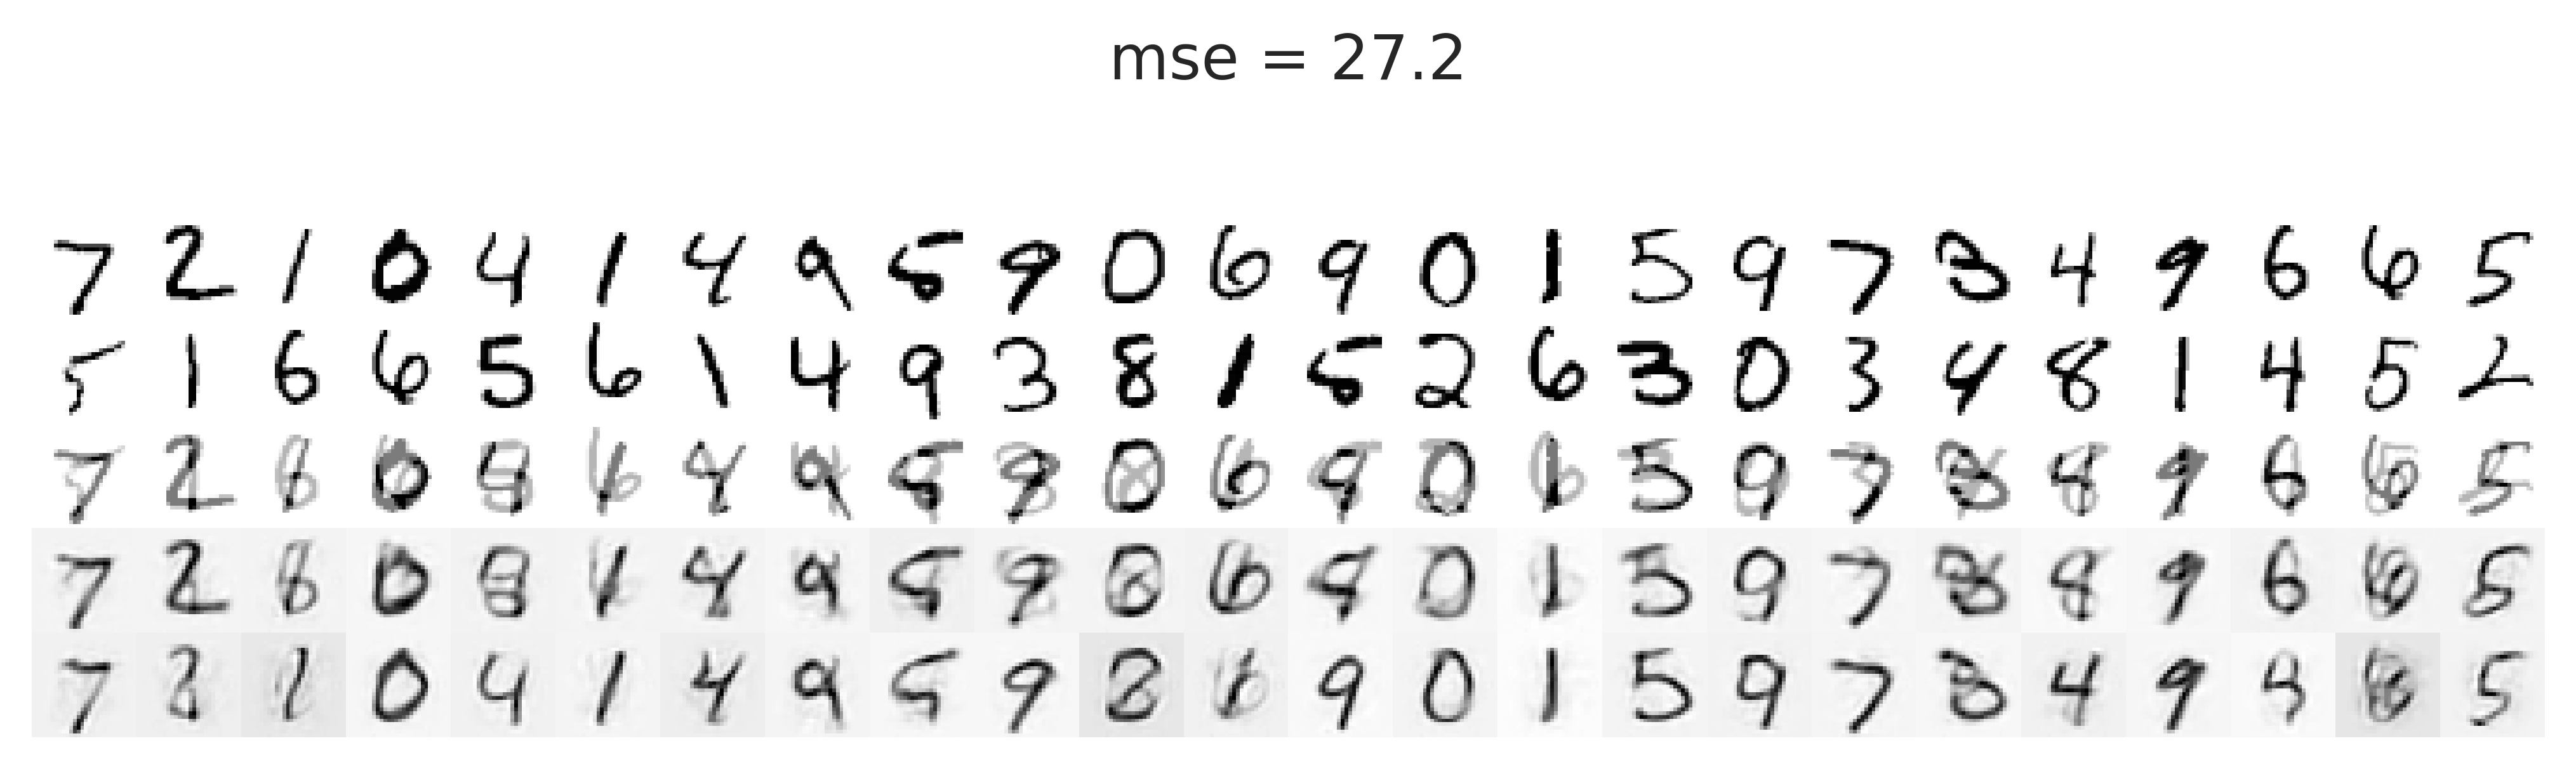

In [39]:
results_8['mse_true'][:10]

array([11.647406 , 25.89552  ,  7.79331  , 21.876137 , 25.748394 ,
        6.7151484, 12.765886 , 16.815144 , 30.066868 , 24.480453 ],
      dtype=float32)

In [40]:
results_64['mse_true'][:10]

array([16.144056 , 45.99544  ,  8.839953 , 17.420189 , 10.905228 ,
        4.2289395, 28.360075 , 22.80429  , 31.912899 , 21.538162 ],
      dtype=float32)

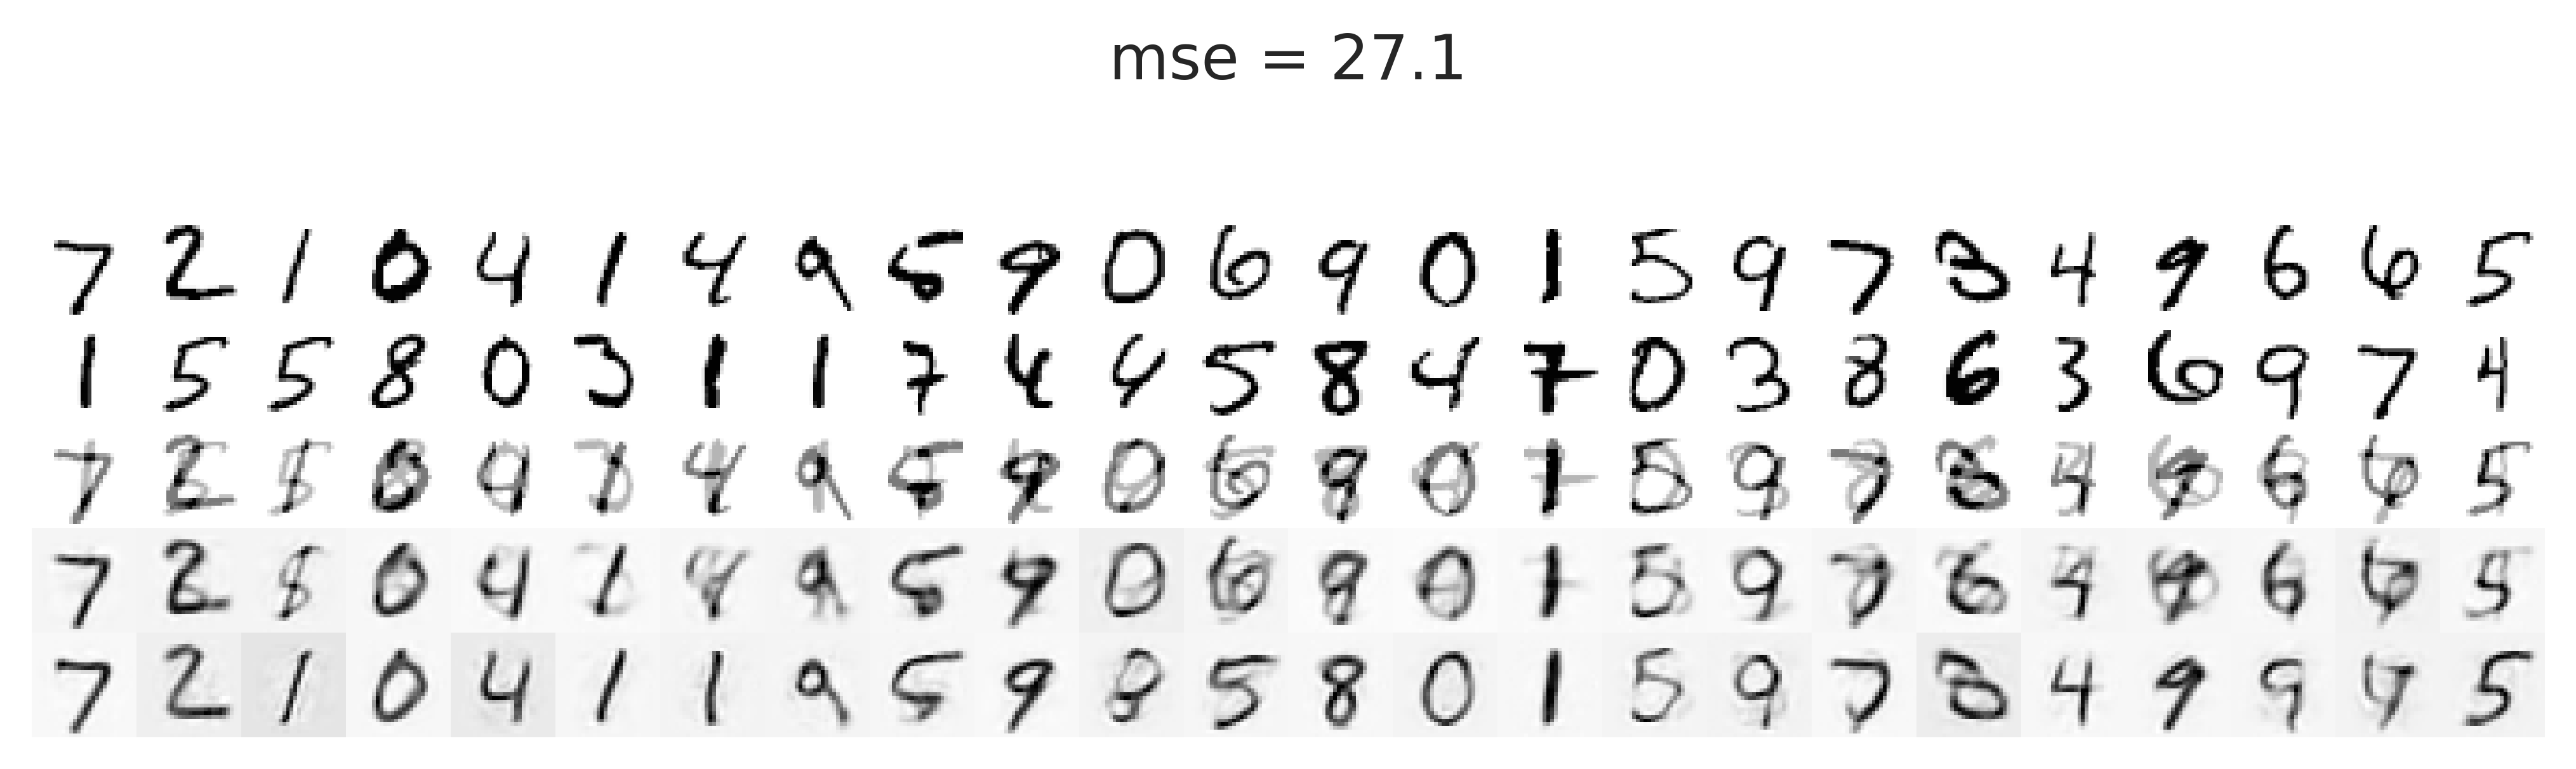

In [24]:
num = 24
x2p = np.concatenate([
    results['x_true'][:num],
    results['x_over'][:num],
    results['x_inpt'][:num],
    results['y_recon'][:num].reshape(shape),
    results['y_halluc'][:num].reshape(shape),
])
fig, ax = plot_weights(x2p, nrows=5, pad=0, dpi=500, cmap='Greys', display=False)
fig.suptitle(f"mse = {results['mse_true'].mean():0.1f}", fontsize=14, y=0.85)
display(fig)

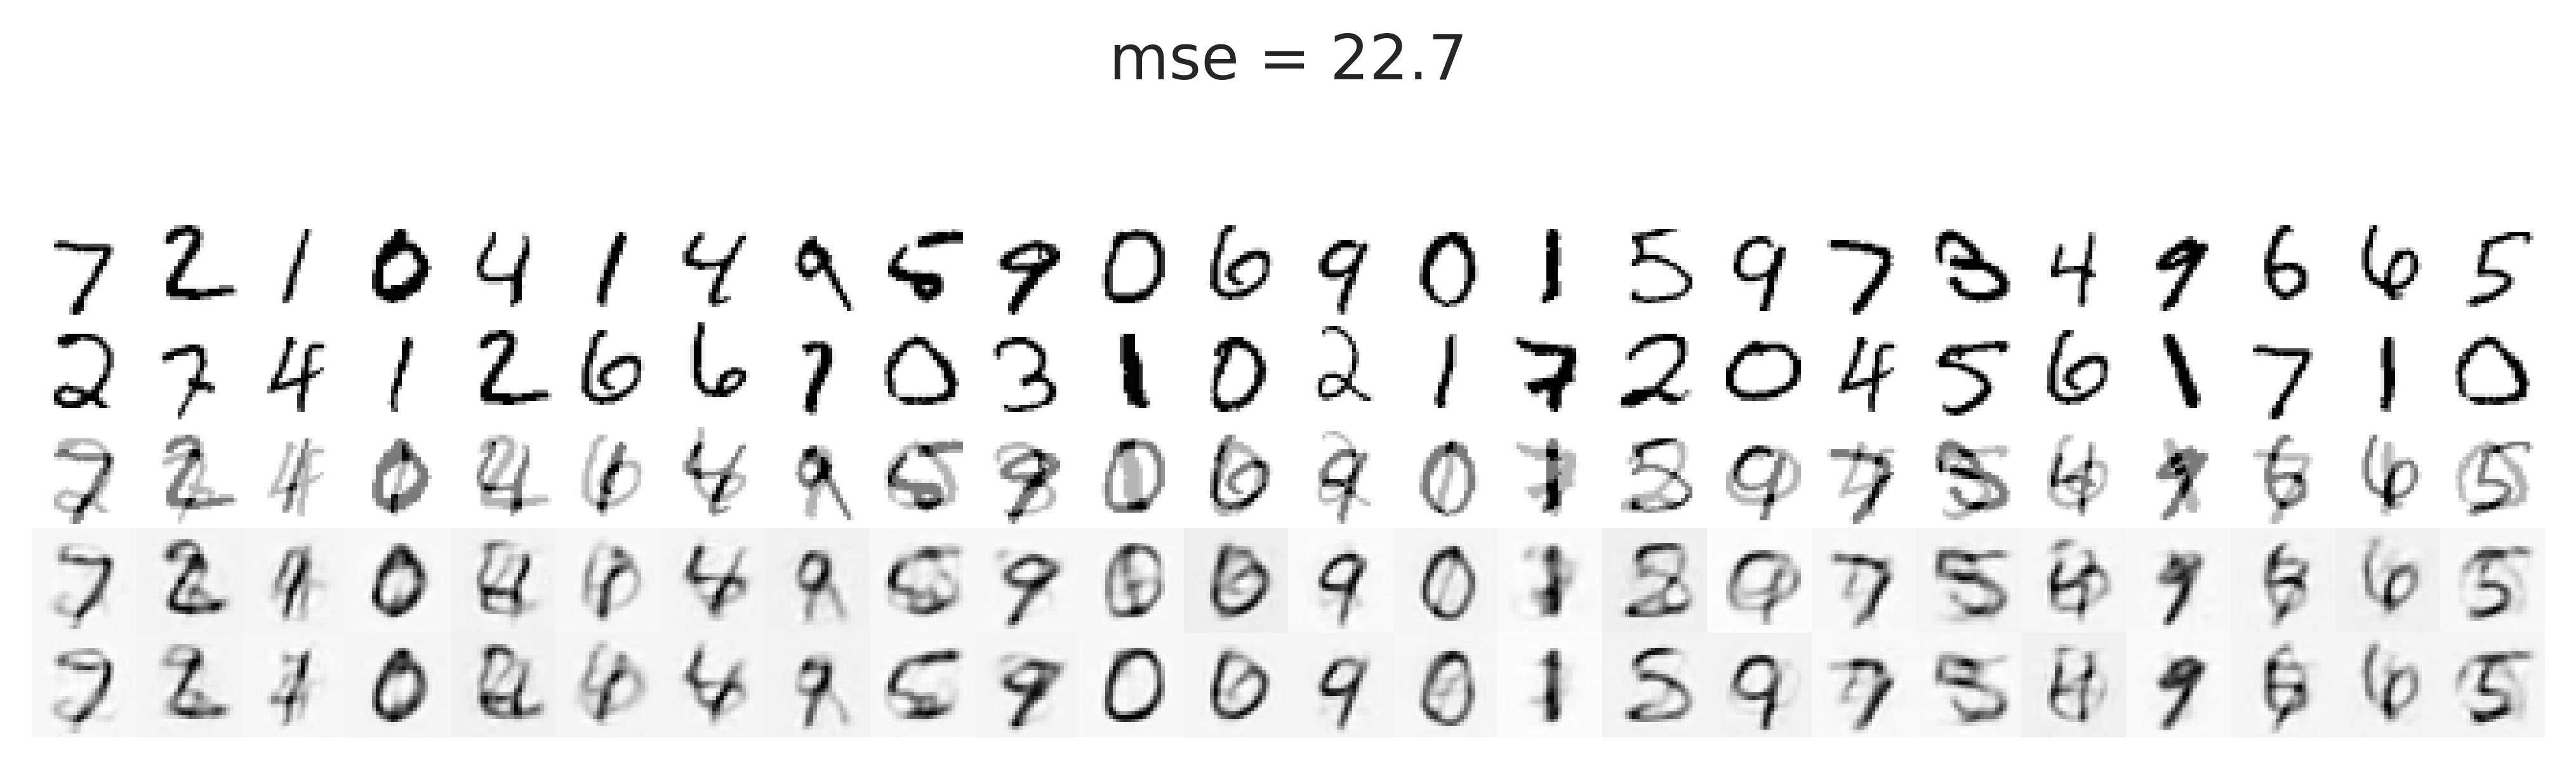

In [37]:
alpha = 0.4

In [49]:
kws = dict(
    tr=trainers['iterative'],
    alpha=alpha,
    t_recon=64,
    t_halluc=64,
    use_pred=True,
    full_data=True,
    verbose=True,
)

results, accu_true, accu_over = perform_overlay_analysis(**kws)

100%|█████████████████████████████████████████| 300/300 [01:22<00:00,  3.62it/s]


In [50]:
accu_true, results['mse_true'].mean(), np.median(results['mse_true'])

(0.6863, 27.241241, 21.717846)

In [52]:
accu_true, accu_over, 1 - (accu_true + accu_over)

(0.6863, 0.2175, 0.09619999999999995)

In [53]:
accu_true / (accu_true + accu_over)

0.7593494135870767

(0.7637, 27.704962, 26.547016)

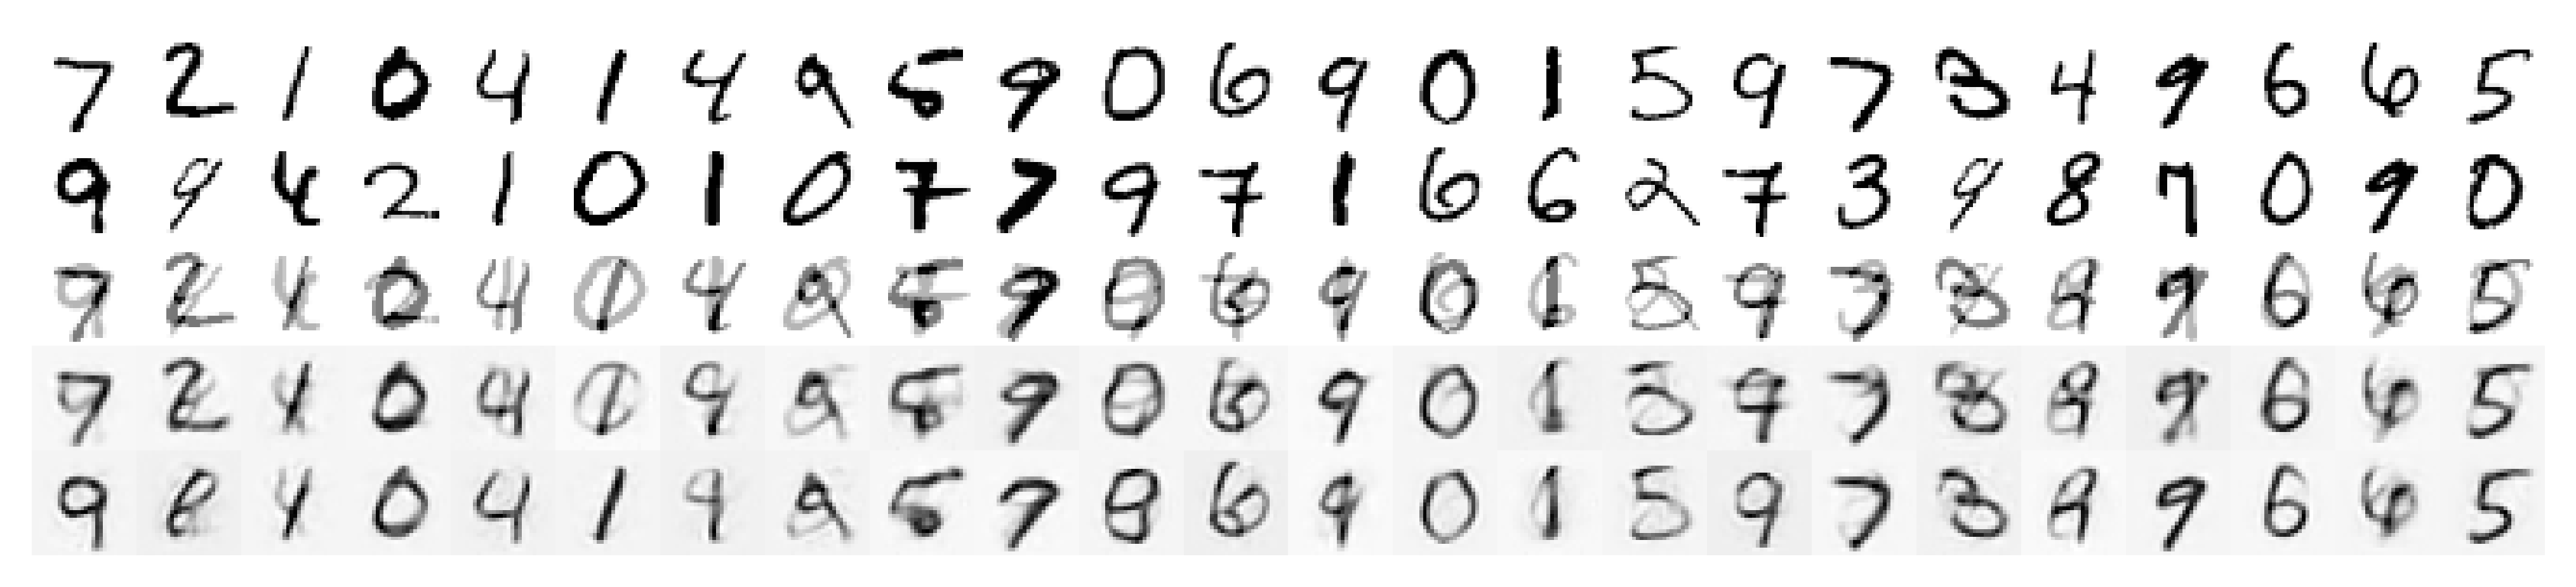

In [45]:
num = 24
x2p = np.concatenate([
    results['x_true'][:num],
    results['x_over'][:num],
    results['x_inpt'][:num],
    results['y_recon'][:num].reshape(shape),
    results['y_halluc'][:num].reshape(shape),
])
_ = plot_weights(x2p, nrows=5, pad=0, dpi=500, cmap='Greys')

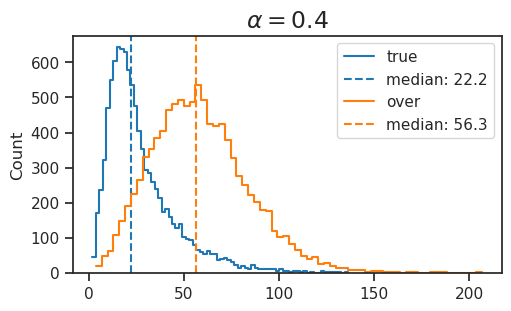

In [11]:
fig, ax = create_figure(1, 1, (5, 3))
for i, key in enumerate(['true', 'over']):
    color = f'C{i}'
    x2p = results[f'mse_{key}']
    histplot(x2p, color=color, label=key, ax=ax)
    median = np.median(x2p)
    ax.axvline(median, color=color, ls='--', label=f"median: {median:0.1f}")
ax.set_title(r"$\alpha = $" + f"{results['alpha']:0.1f}", fontsize=17)
plt.legend()
plt.show()

In [12]:
accu_true, accu_over, 1 - (accu_true + accu_over)

(0.7017, 0.1979, 0.10040000000000004)

In [13]:
results['alpha'], accu_true / (accu_true + accu_over)

(0.4, 0.7800133392618942)

In [14]:
(results['g_true'] == results['g_over']).mean()

0.0

### amortized

In [15]:
kws['tr'] = trainers['amortized']
results, accu_true, accu_over = perform_overlay_analysis(**kws)

100%|████████████████████████████████████████| 300/300 [00:01<00:00, 199.28it/s]


In [16]:
results['alpha']

0.4

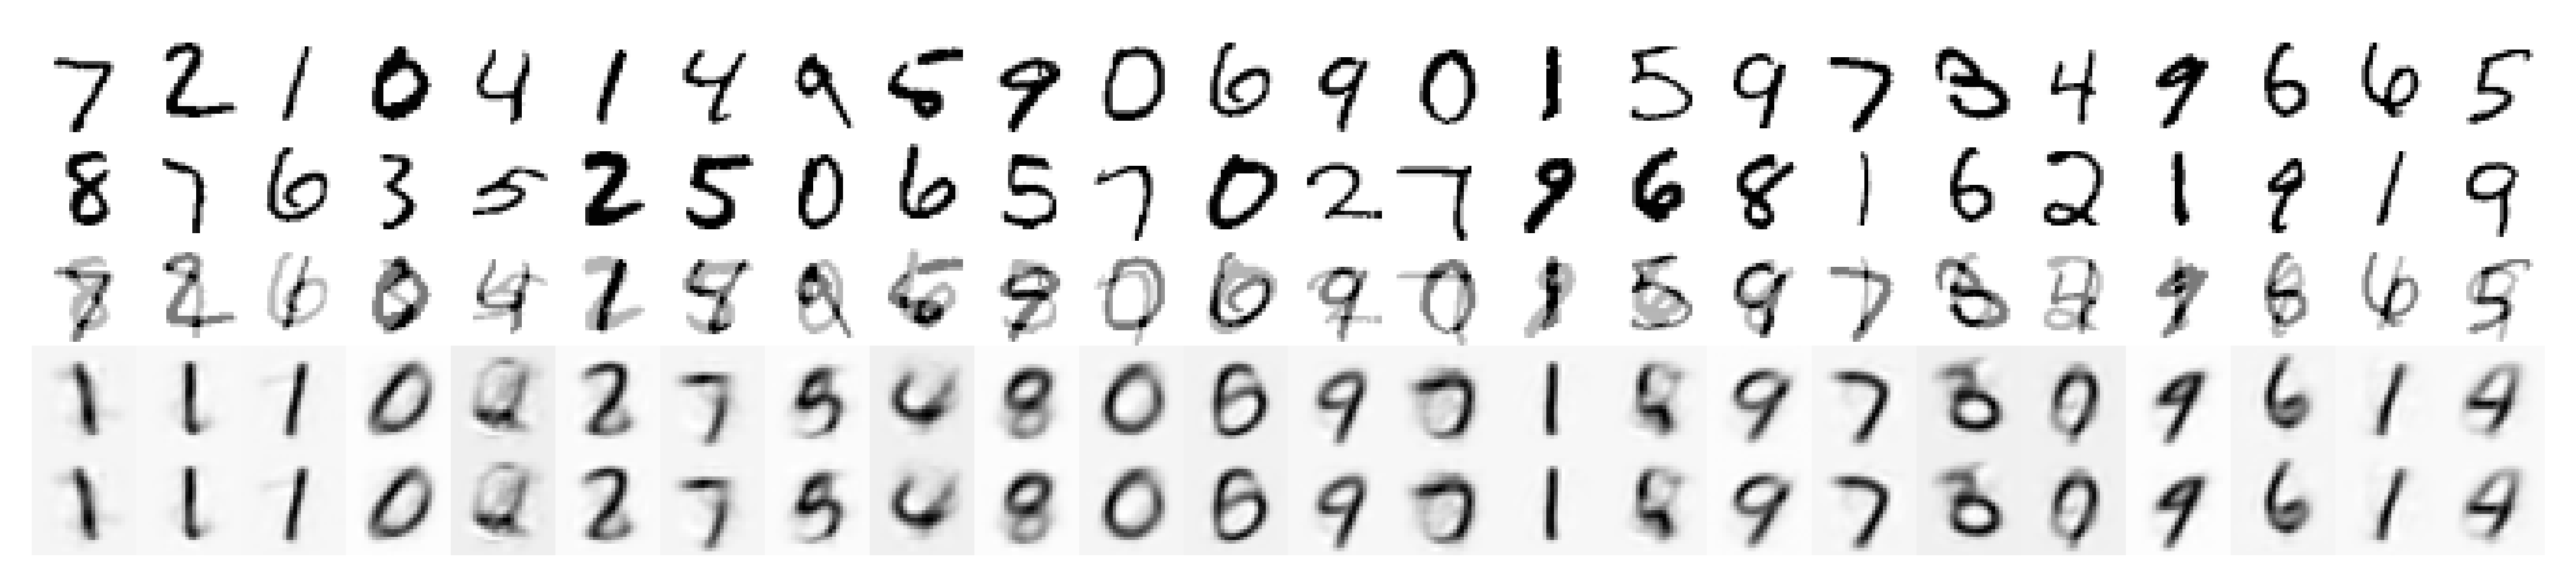

In [17]:
num = 24
x2p = np.concatenate([
    results['x_true'][:num],
    results['x_over'][:num],
    results['x_inpt'][:num],
    results['y_recon'][:num].reshape(shape),
    results['y_halluc'][:num].reshape(shape),
])
_ = plot_weights(x2p, nrows=5, pad=0, dpi=500, cmap='Greys')

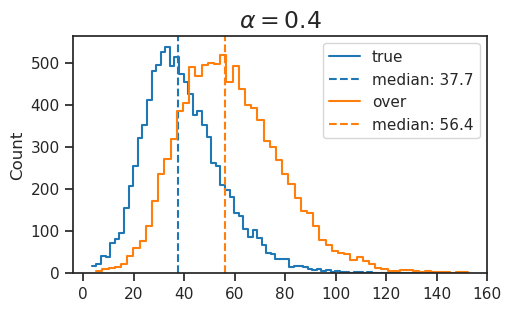

In [18]:
fig, ax = create_figure(1, 1, (5, 3))
for i, key in enumerate(['true', 'over']):
    color = f'C{i}'
    x2p = results[f'mse_{key}']
    histplot(x2p, color=color, label=key, ax=ax)
    median = np.median(x2p)
    ax.axvline(median, color=color, ls='--', label=f"median: {median:0.1f}")
ax.set_title(r"$\alpha = $" + f"{results['alpha']:0.1f}", fontsize=17)
plt.legend()
plt.show()

In [19]:
accu_true, accu_over, 1 - (accu_true + accu_over)

(0.7336, 0.1388, 0.12759999999999994)

In [20]:
results['alpha'], accu_true / (accu_true + accu_over)

(0.4, 0.8408986703347088)

## Older stuff

In [9]:
x, g = next(iter(tr.dl_vld))
# x_over, inds = create_overlaid_data(x, 0.3)

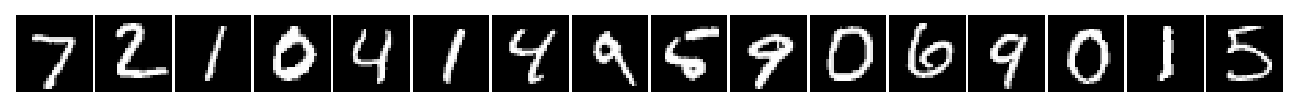

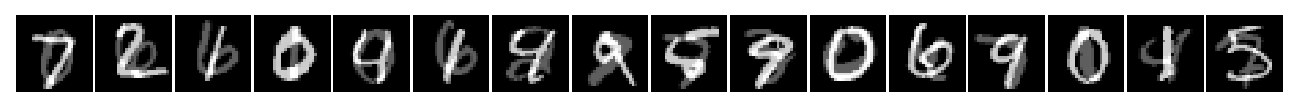

In [38]:
_ = plot_weights(x[:16], nrows=1)
_ = plot_weights(x_over[:16], nrows=1)

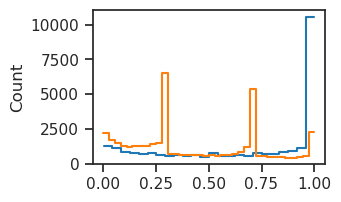

In [39]:
x2p = tonp(x.ravel())
x2p = x2p[x2p > 0]
histplot(x2p)

x2p = tonp(x_over.ravel())
x2p = x2p[x2p > 0]
histplot(x2p);

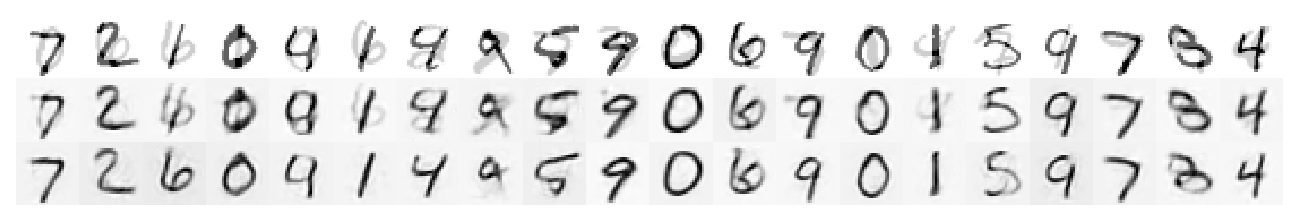

In [42]:
t_recon = 32
t_halluc = 64

output_recon = tr.model.xtract_ftr(
    x=x_over,
    seq=range(0, t_recon),
    return_extras=True,
).stack()

output_halluc = tr.model.xtract_ftr(
    x=x_over,
    seq=range(t_recon, t_recon + t_halluc),
    return_extras=True,
    override_x=True,
).stack()

y_recon = output_recon['recon'][:, -1, :]
y_halluc = output_halluc['recon'][:, -1, :]
y_recon = y_recon.reshape(shape)
y_halluc = y_halluc.reshape(shape)

num = 20
x2p = torch.cat([x_over[:num], y_recon[:num], y_halluc[:num]])
_ = plot_weights(x2p, nrows=3, pad=0, cmap='Greys')

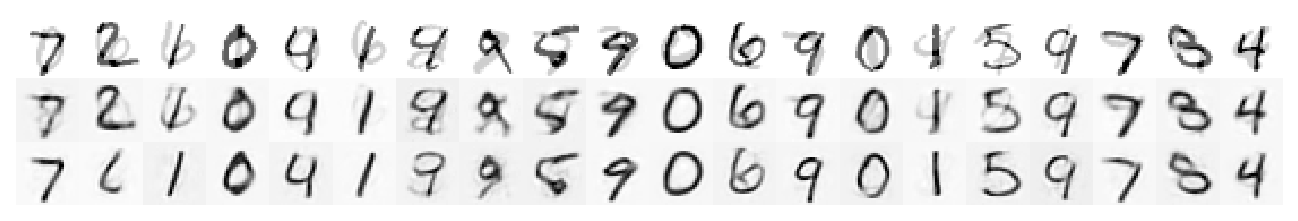

In [41]:
t_recon = 32
t_halluc = 64

output_recon = tr.model.xtract_ftr(
    x=x_over,
    seq=range(0, t_recon),
    return_extras=True,
).stack()

output_halluc = tr.model.xtract_ftr(
    x=tr.model.pred,
    seq=range(t_recon, t_recon + t_halluc),
    return_extras=True,
    override_x=True,
).stack()

y_recon = output_recon['recon'][:, -1, :]
y_halluc = output_halluc['recon'][:, -1, :]
y_recon = y_recon.reshape(shape)
y_halluc = y_halluc.reshape(shape)

num = 20
x2p = torch.cat([x_over[:num], y_recon[:num], y_halluc[:num]])
_ = plot_weights(x2p, nrows=3, pad=0, cmap='Greys')

In [47]:
torch.allclose(output_halluc['state'][:, -1, :], tr.model.state)

True

In [48]:
torch.allclose(output_halluc['recon'][:, -1, :], tr.model.pred)

True

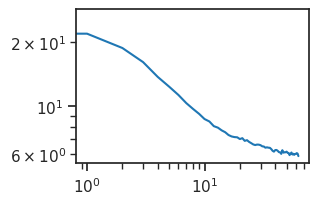

In [210]:
plt.loglog(tonp(output['loss_recon'].mean(0)))

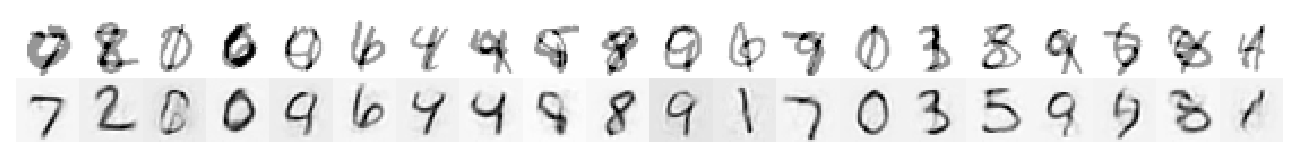

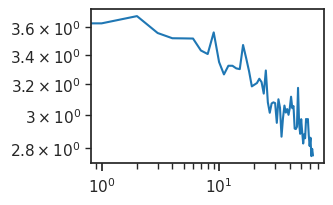

In [169]:
plt.loglog(tonp(output['loss_recon'].mean(0)))